# **Install and import necessary packages**

In [1]:
import os
import json
import gdown
import pandas as pd
import numpy as np
import sys
!pip install scikit-surprise
from surprise import SVDpp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader, SVD
!pip install git+https://github.com/microsoft/recommenders.git
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (
    map, ndcg_at_k, precision_at_k, recall_at_k
)
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader
from sklearn.metrics import f1_score, precision_score, recall_score
from scipy.sparse import hstack
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns

  Cloning https://github.com/microsoft/recommenders.git to /tmp/pip-req-build-23tjm7qe
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/recommenders.git /tmp/pip-req-build-23tjm7qe
  Resolved https://github.com/microsoft/recommenders.git to commit c2ea583d27bb1a4d58a09a1621d5ce95672ef1dc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  Using cached sentence_transformers-2.6.1-py3-none-any.whl (163 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64

# **Load dataset**

In [2]:
!gdown https://drive.google.com/uc?id=1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0data = pd.read_csv('final_dataset.csv', dtype = {'Movie': 'string', 'Reviewer': 'string', 'Review': 'string', 'Score': 'float64', 'Sentiment_scores': 'float64', 'overview': 'string', 'recommend': 'int'}, parse_dates=['Date'])# link to csv: https://drive.google.com/file/d/1vbteMX-kHyYAAS7JIrrog_aZvvOY77Q0/view?usp=drive_link
# data = pd.read_csv('/content/drive/MyDrive/bt4222 project/final_dataset.csv', dtype = {'Movie': 'string', 'Reviewer': 'string', 'Review': 'string', 'Score': 'float64', 'Sentiment_scores': 'float64', 'overview': 'string', 'recommend': 'int'}, parse_dates=['Date'])
print(data.columns)
print(data.head())

Index(['Movie', 'Reviewer', 'Review', 'Score', 'Sentiment_scores', 'overview',
       'cast_list', 'crew_list', 'director_list', 'first_three_casts',
       'unique_genres', 'Date', 'recommend'],
      dtype='object')
       Movie          Reviewer  \
0  SENSATION   Dennis Schwartz   
1  SENSATION  Carey-Ann Pawsey   
2  SENSATION        Rob Rector   
3  SENSATION        Rich Cline   
4  SENSATION       Allen Adams   

                                              Review     Score  \
0  A sci-fi film that made no sense, as it tells ...  0.686869   
1  A thriller that ultimately makes little to no ...  0.393939   
2  There's still much to admire with Sensation, d...  0.595960   
3  There's no thematic depth in the story or char...  0.494949   
4  Sensation wants to be a deep movie...[but] tho...  0.393939   

   Sentiment_scores                                           overview  \
0          0.276348  Man-boy farmer Donal discovers that his father...   
1          0.334176  Man-boy far

# **Prepare training and test sets**

In [ ]:
#split data into train and test sets, make sure that only users and items present in train set appear in test set
cf_data = data.loc[:, ['Reviewer', 'Movie', 'Score']]
train, test = train_test_split(cf_data, test_size = 0.15, random_state = 42, shuffle = True)
test = test[test["Reviewer"].isin(train["Reviewer"].unique())]
test = test[test["Movie"].isin(train["Movie"].unique())]

# **Content-based filtering**



*   create a dataset of unique movies
*   preprocess overview



In [3]:
#keep only unique movies
unique_movies = data.drop_duplicates(subset='Movie')
unique_movies = unique_movies.reset_index()

#preprocess overview
def process_text(text):
    processed_text = ""
    lower_text = text.lower()
    tokenized_text = word_tokenize(lower_text)
    alphabetic_tokens = [token for token in tokenized_text if re.match('^[a-zA-Z]+$', token)]
    lemmatized_words = [WordNetLemmatizer().lemmatize(token) for token in alphabetic_tokens]
    processed_text = ' '.join(lemmatized_words)
    return processed_text

unique_movies['processed_overview'] = unique_movies['overview'].apply(lambda x: process_text(x))




*   convert genres to lower case and combine into 1 string
*   convert director list to lower case, join first and last name, combine into 1 string
*   convert first 3 casts to lower case, join first and last name, combine into 1 string







In [4]:
#convert genres to lowercase and combine into 1 long string
unique_movies['unique_genres'] = unique_movies['unique_genres'].apply(lambda x: eval(x))
unique_movies['processed_genres'] = unique_movies['unique_genres'].apply(lambda x: ' '.join([word.lower() for word in x]))
print(unique_movies['processed_genres'])

#convert director list to lower case, join first and last name, combine into 1 long string
unique_movies['director_list'] = unique_movies['director_list'].apply(lambda x: eval(x))

def process_names(names_list):
  processed_names = [''.join(name.lower().split()) for name in names_list]
  return ' '.join(processed_names)

unique_movies['processed_directors'] = unique_movies['director_list'].apply(lambda x: process_names(x))
print(unique_movies['processed_directors'])

#convert first 3 casts to lower case, join first and last name, combine into 1 long string
unique_movies['first_three_casts'] = unique_movies['first_three_casts'].apply(lambda x: eval(x))
unique_movies['processed_cast'] = unique_movies['first_three_casts'].apply(lambda x: process_names(x))
print(unique_movies['processed_cast'])

0       drama romance comedy foreign
1                  drama history war
2                   thriller mystery
3                             comedy
4             drama thriller mystery
                    ...             
5211                          comedy
5212           drama thriller comedy
5213                        thriller
5214       drama history war foreign
5215                  romance comedy
Name: processed_genres, Length: 5216, dtype: object
0                           tomhall
1                     romanpolanski
2                  wolfgangpetersen
3                      chuckvincent
4                  barbarastepansky
                   ...             
5211    jasonfriedberg aaronseltzer
5212                      henrybean
5213                    chrisjaymes
5214                 enniodeconcini
5215                     carlreiner
Name: processed_directors, Length: 5216, dtype: object
0                luannegordon kellycampbell owenroe
1                jonfinch francescaann



*   Combine overview, genres, directors and first 3 casts into one string
*   Create a count vectorizer and a bert model



In [5]:
#combine overview and genres into 1 long string (soup)
unique_movies['soup'] = unique_movies['processed_overview'] + ' ' + unique_movies['processed_genres'] + ' ' + unique_movies['processed_directors'] + ' ' + unique_movies['processed_cast']
print(unique_movies['soup'][0])

#create a count vectorizer
count_vectorizer = CountVectorizer(analyzer='word', stop_words='english')
count_matrix = count_vectorizer.fit_transform(unique_movies['soup'])

#create soup2 for bert
unique_movies['soup2'] = unique_movies['overview'] + ' ' + unique_movies['processed_genres'] + ' ' + unique_movies['processed_directors'] + ' ' + unique_movies['processed_cast']

#create bert model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
embeddings = bert_model.encode(unique_movies["soup2"], show_progress_bar=True)

farmer donal discovers that his father ha suddenly passed away now on his own donal attempt to lose his virginity by hiring a prostitute to help him get out of his rut and so he meet kim an aging kiwi escort after engaging in a strictly sexual encounter their relationship soon progress into a lusty romance then to a business enterprise between two partner through these exploit donal and kim provide each other with a sense of love and belonging that neither experienced beforehand drama romance comedy foreign tomhall luannegordon kellycampbell owenroe


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/163 [00:00<?, ?it/s]

In [6]:
print(unique_movies['Movie'].head(50))


0                  SENSATION
1     THE TRAGEDY OF MACBETH
2                  SHATTERED
3                 SEX APPEAL
4                       HURT
5                 CINDERELLA
6                   BETRAYED
7                      GREED
8               SILENT NIGHT
9              BOILING POINT
10              BLACK FRIDAY
11         THIS IS THE NIGHT
12                      BUGS
13                THE GRUDGE
14                 DANGEROUS
15                      DUNE
16           HELD FOR RANSOM
17                  JOY RIDE
18                 ISOLATION
19                WITCH HUNT
20                 IMPLANTED
21             ICE GUARDIANS
22                   STALKER
23                     HABIT
24              REMINISCENCE
25                THE COLONY
26         UNDER THE VOLCANO
27                  TOO LATE
28                   DEMONIC
29                       PIG
30                     TWIST
31                  THE EAST
32                      ROMA
33               THE PHANTOM
34            

**Create cosine scores for the matrix derived from the count vectorizer and the embedding from the BERT model**

In [7]:
#calculate cosine similarity
cosine_scores = cosine_similarity(count_matrix)
cosine_scores_bert = cosine_similarity(embeddings)

# Flatten the cosine similarity matrix into a 1D array
cosine_scores_flat = cosine_scores.flatten()
cosine_scores_bert_flat = cosine_scores_bert.flatten()

**Compare densities of cosine similarity scores derived from BERT and from count vectorizer**



*   Cosine similarity scores derived from BERT will be used as the distribution is much more even.





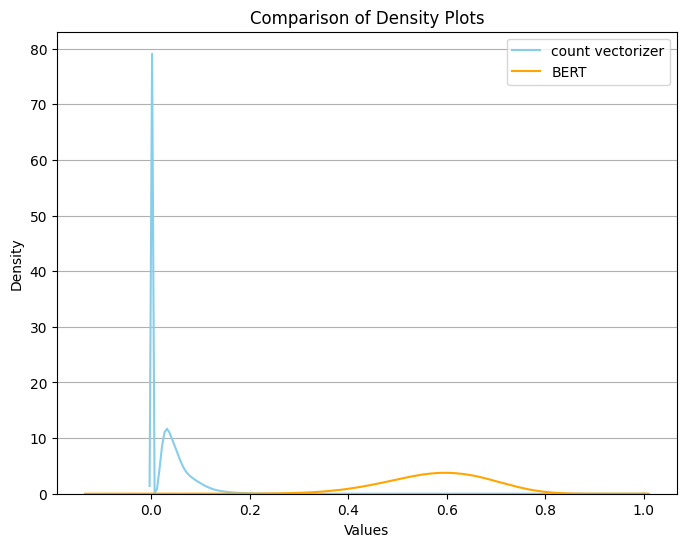

In [8]:
# Plot a density plot
plt.figure(figsize=(8, 6))
sns.kdeplot(cosine_scores_flat, color='skyblue', label='count vectorizer')
sns.kdeplot(cosine_scores_bert_flat, color='orange', label='BERT')
plt.title('Comparison of Density Plots')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y')
plt.show()

In [11]:
percentile_75 = np.percentile(cosine_scores_bert_flat, 75)
print(percentile_75)

0.6548719555139542


**Test and evaluate content based filtering**


*   If movie has cosine similarity score >= percentile_75, recommend
*   Warning: this takes around 50 minutes to run







In [56]:
#for each user, look at all movies liked. if current movie has similarity score  >= percentile_75 with any of the movies liked, recommend = 1
predicted_user_ratings = []
real_user_ratings = []

for index, row in test.iterrows():
  user = row['Reviewer']
  movie = row['Movie']
  recommend = 1 if row['Score'] > 0.797980 else 0
  real_user_ratings.append({'Reviewer': user, 'Movie': movie, 'Actual_Score': recommend})
  #for each user, movie pair, get the cosine similarity between this movie and other movies watched by the user. if exceed a certain threshold, recommend
  all_movies_liked = data[(data['Reviewer'] == user) & (data['Movie'] != movie) & (data['recommend'] == 1)]['Movie'].tolist()
  #find this movie's index in unique_movies
  curr_movie_index = unique_movies.index[unique_movies['Movie'] == movie][0]
  similar = 0
  for movie in all_movies_liked:
    index = unique_movies.index[unique_movies['Movie'] == movie][0]
    sim_score = cosine_scores_bert[curr_movie_index][index]
    if (sim_score >= percentile_75):
      similar = 1
      break
  predicted_user_ratings.append({'Reviewer': user, 'Movie': movie, 'Predicted_Score': similar})

predicted_user_ratings = pd.DataFrame(predicted_user_ratings, columns = ['Reviewer', 'Movie', 'Predicted_Score'])
real_user_ratings = pd.DataFrame(real_user_ratings, columns = ['Reviewer', 'Movie', 'Actual_Score'])

In [57]:
# Precision
precision = precision_at_k(rating_pred = predicted_user_ratings, rating_true = real_user_ratings, k = 10, col_user='Reviewer', col_item='Movie', col_rating='Actual_Score', col_prediction = 'Predicted_Score')
print(f'Precision: {precision}')

# Recall
recall = recall_at_k(rating_pred = predicted_user_ratings, rating_true = real_user_ratings, k = 10, col_user='Reviewer', col_item='Movie', col_rating='Actual_Score', col_prediction = 'Predicted_Score')
print(f'Recall: {recall}')


#F1 score
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f'F1 Score: {f1}')


Precision: 0.11787644787644791
Recall: 0.3026918307313103
F1 Score: 0.1696763147517503


**Recommending top 10 movies using content based filtering**

In [18]:
#content based filtering method
def recommend_movies(movie, cosine_scores, unique_movies, top_n=10):
    movie_index = unique_movies[unique_movies['Movie'] == movie].index[0]
    sim_scores = list(enumerate(cosine_scores[movie_index]))
    sim_scores.sort(key=lambda x: x[1], reverse=True)

    # Get top n similar movies (excluding the input movie itself)
    top_movies = sim_scores[1:top_n + 1]

    # Extract movie titles from indices
    recommended_movies = [(unique_movies.iloc[i]['Movie'], cosine_scores[movie_index][i]) for i, _ in top_movies]

    return recommended_movies

In [20]:
#test content based filtering
recommended_movies = recommend_movies('INTERSTELLAR', cosine_scores_bert, unique_movies)
print(pd.DataFrame(recommended_movies, columns = ['Movie', 'Cosine_Scores_Bert']))

                           Movie  Cosine_Scores_Bert
0                     PROMETHEUS            0.866442
1               STAR TREK BEYOND            0.856962
2                RATCHET & CLANK            0.841057
3        APPROACHING THE UNKNOWN            0.834513
4   ROGUE ONE: A STAR WARS STORY            0.828726
5                 FANTASTIC FOUR            0.828568
6            ABSOLUTELY ANYTHING            0.823955
7  STARSHIP TROOPERS 3: MARAUDER            0.820990
8                       IRON SKY            0.820149
9                           LIFE            0.820113


# **Collaborative filtering using SVD**

**Train SVD model and make predictions**

In [22]:
#prepare training set
rating_scale = (train['Score'].min(), train['Score'].max())
reader = Reader(rating_scale=rating_scale)
svd_train = Dataset.load_from_df(train, reader).build_full_trainset()

In [86]:
#train svd
svd = SVD(random_state=42, n_factors=200, n_epochs=30, verbose=True)
svd.fit(svd_train)

test = test[['Reviewer', 'Movie', 'Score']]
testset = list(test.apply(tuple, axis=1))
test_predictions = svd.test(testset)

trainset = list(train.apply(tuple, axis = 1))
train_predictions = svd.test(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29


**Evaluate SVD model performance on test set**

In [24]:
# Evaluation of SVD Model
def rating_grouping(rating):
    if (rating > 0.797980):
        return 1
    else:
        return 0

# Extract true and predicted ratings from the predictions
real_user_ratings = pd.DataFrame([(pred.uid, pred.iid, rating_grouping(pred.r_ui)) for pred in test_predictions], columns=['Reviewer', 'Movie', 'Actual_Rating'])
predicted_ratings = pd.DataFrame([(pred.uid, pred.iid, rating_grouping(pred.est)) for pred in test_predictions], columns=['Reviewer', 'Movie', 'Predicted_Rating'])

# Precision
precision = precision_at_k(rating_pred = predicted_ratings, rating_true = real_user_ratings, k = 10, col_user='Reviewer', col_item='Movie', col_rating='Actual_Rating', col_prediction = 'Predicted_Rating')
print(f'Precision: {precision}')

# Recall
recall = recall_at_k(rating_pred = predicted_ratings, rating_true = real_user_ratings, k = 10, col_user='Reviewer', col_item='Movie', col_rating='Actual_Rating', col_prediction = 'Predicted_Rating')
print(f'Recall: {recall}')


#F1 score
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f'F1 Score: {f1}')

Precision: 0.5186486486486487
Recall: 0.8165973886266172
F1 Score: 0.6343806613580666


# **Hybrid Recommendation System**

**Evaluate hybrid recommendation system performance on test set**

*   Recommend if similarity score >= percentile_75 or predicted rating > 0.797980
*   Warning: this takes around 50 minutes to run



In [32]:
def rating_grouping(pred):
  if (pred.r_ui > 0.797980):
    return 1
  else:
    return 0

def predict_grouping(pred):
  #for each user, movie pair, get the cosine similarity between this movie and other movies watched by the user. if exceed a certain threshold, recommend
  all_movies_liked = data[(data['Reviewer'] == pred.uid) & (data['Movie'] != pred.iid) & (data['recommend'] == 1)]['Movie'].tolist()
  #find this movie's index in unique_movies
  curr_movie_index = unique_movies.index[unique_movies['Movie'] == pred.iid][0]
  similar = 0
  for movie in all_movies_liked:
    index = unique_movies.index[unique_movies['Movie'] == movie][0]
    sim_score = cosine_scores_bert[curr_movie_index][index]
    if (sim_score >= percentile_75):
      similar = 1
      break
  if ((similar == 1) or (pred.est > 0.797980)):
      return 1
  else:
    return 0
# Extract true and predicted ratings from the predictions
real_user_ratings = pd.DataFrame([(pred.uid, pred.iid, rating_grouping(pred)) for pred in test_predictions], columns=['Reviewer', 'Movie', 'Actual_Rating'])
predicted_ratings = pd.DataFrame([(pred.uid, pred.iid, predict_grouping(pred)) for pred in test_predictions], columns=['Reviewer', 'Movie', 'Predicted_Rating'])

# Precision
precision = precision_at_k(rating_pred = predicted_ratings, rating_true = real_user_ratings, k = 10, col_user='Reviewer', col_item='Movie', col_rating='Actual_Rating', col_prediction = 'Predicted_Rating')
print(f'Precision: {precision}')

# Recall
recall = recall_at_k(rating_pred = predicted_ratings, rating_true = real_user_ratings, k = 10, col_user='Reviewer', col_item='Movie', col_rating='Actual_Rating', col_prediction = 'Predicted_Rating')
print(f'Recall: {recall}')


#F1 score
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f'F1 Score: {f1}')

Precision: 0.5186872586872587
Recall: 0.8166034911439519
F1 Score: 0.6344113839018845


**Demonstrate top 10 movie recommendations using hybrid recommendation system**

In [83]:
def hybrid_recommend(user):
  all_movies_watched = data[data['Reviewer'] == user]['Movie'].tolist()
  all_movies_liked = data[(data['Reviewer'] == user) & (data['recommend'] == 1)]['Movie'].tolist()
  columns = {
    'Movie': [],
    'Cosine_Similarity_Score': [],
  }
  unique_movies['predicted_rating_hybrid'] = unique_movies['Movie'].apply(lambda x: svd.predict(user, x).est)
  highly_rated_movies = unique_movies[unique_movies['predicted_rating_hybrid'] > 0.797980]
  highly_rated_movies = highly_rated_movies[['Movie', 'predicted_rating_hybrid']]
  highly_rated_movies = highly_rated_movies.sort_values(['predicted_rating_hybrid'], ascending = False)

  # Create an empty DataFrame with columns
  similar_movies = pd.DataFrame(columns)

  for movie in all_movies_liked:
    movie_index = unique_movies[unique_movies['Movie'] == movie].index[0]
    sim_scores = list(enumerate(cosine_scores_bert[int(movie_index)]))
    sim_scores_filtered = [(i, sim_score) for i, sim_score in sim_scores if unique_movies.iloc[i]['Movie'] != movie and sim_score >= percentile_75]
    movies = pd.DataFrame([(unique_movies.iloc[i]['Movie'], _) for i, _ in sim_scores_filtered], columns = ['Movie', 'Cosine_Similarity_Score'])
    similar_movies = pd.concat([similar_movies, movies], axis=0)

  similar_movies = similar_movies.sort_values(['Cosine_Similarity_Score'], ascending = False)

  final_movies = pd.merge(highly_rated_movies, similar_movies, on = 'Movie', how = 'outer')
  final_movies = final_movies.drop_duplicates(subset = 'Movie')
  final_movies = final_movies[~final_movies['Movie'].isin(all_movies_watched)]

  return (final_movies.head(10))['Movie']

In [84]:
hybrid_recommend('Sara Stewart')

0                    KES
1     DO THE RIGHT THING
2                     UP
5               LE HAVRE
16              45 YEARS
17               BOYHOOD
18              PARASITE
24             PINOCCHIO
25         SHERLOCK, JR.
32       STORIES WE TELL
Name: Movie, dtype: object